In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
# Tickers for Gold, S&P 500
tickers = ["^GSPC", "GC=F"]
df = yf.download(tickers, start="2000-01-01", end="2026-01-01")['Close'].dropna()

# Renaming our Gold and S&P 500 for better understanding
df.columns = ['Gold', 'SP500']

/tmp/ipython-input-3574353578.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  2 of 2 completed


In [ ]:
df.head()

,Gold,SP500
Date,,
2000-08-30,273.899994,1502.589966
2000-08-31,278.299988,1517.680054
2000-09-01,277.000000,1520.770020
2000-09-05,275.799988,1507.079956
2000-09-06,274.200012,1492.250000


In [ ]:
# Plotting the Gold and S&P 500

fig = go.Figure()

colors = {'SP500': 'blue', 'Gold': 'gold'}

for col in df.columns:
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df[col],
        name=col,
        line=dict(color=colors.get(col, 'black'))
    ))

fig.update_layout(
    title='S&P 500 and Gold',
    xaxis=dict(rangeslider_visible=True),
    yaxis_title="Values",
    template="plotly_white"
)
fig.show()

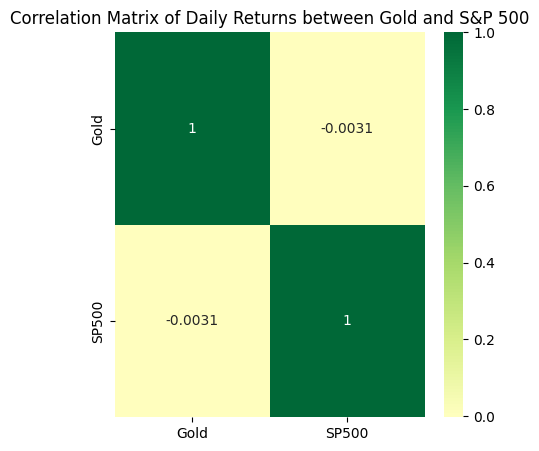

In [ ]:
# Calculating Daily returns for the Correlation Analysis
returns = df.pct_change().dropna()

# Correlation between Gold and S&P 500
plt.figure(figsize=(5, 5))
plt.title('Correlation Matrix of Daily Returns between Gold and S&P 500')
sns.heatmap(returns.corr(), annot=True, cmap='RdYlGn', center=0)
plt.show()

In [ ]:
# Checking for any empty values in the dataset
print(df.isnull().sum())

Gold     0
SP500    0
dtype: int64


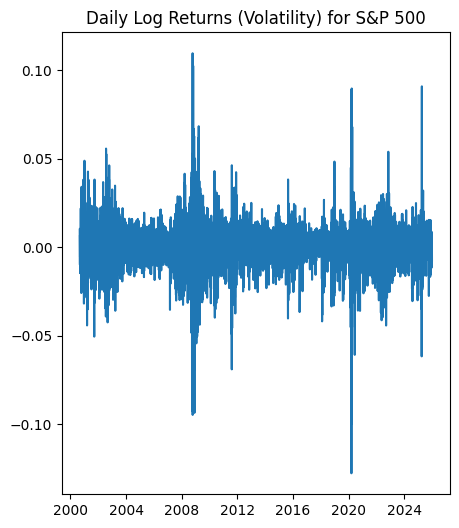

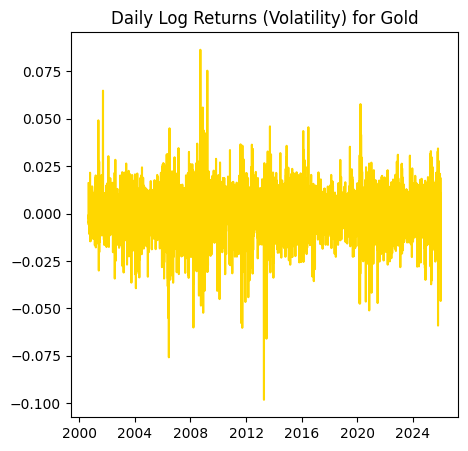

In [ ]:
# Visualising the Volatility

# Calculating Log Returns
log_returns = np.log(df/ df.shift(1)).dropna()

# Log returns for S&P 500
plt.figure(figsize=(5,6))
plt.title('Daily Log Returns (Volatility) for S&P 500')
plt.plot(log_returns['SP500'])
plt.show()

# Log returns for Gold
plt.figure(figsize=(5,5))
plt.title('Daily Log Returns (Volatility) for Gold')
plt.plot(log_returns['Gold'], color='gold')
plt.show()

In [ ]:
# Plot for S&P and Gold with Moving Averages

sp_500 = df['SP500'].tolist()
gold = df['Gold'].tolist()

# The windows for the Rolling Mean or Simple Moving Averages for 50 and 200 Days
w = 50
v = 200


# 50 Day Moving Average for the S&P 500
df['SP_SMA_50'] = [
    sum(sp_500[i-(w-1) : i+1]) / w if i >= w-1 else None
    for i in range(len(sp_500))
]

# 200 Day Moving Average for the S&P 500
df['SP_SMA_200'] = [
    sum(sp_500[i-(v-1) : i+1]) / v if i >= v-1 else None
    for i in range(len(sp_500))
]

# 50 Day Moving Average for Gold
df['Gold_SMA_50'] = [
    sum(gold[i-(w-1) : i+1]) / w if i >= w-1 else None
    for i in range(len(gold))
]

# 200 Day Moving Average for Gold
df['Gold_SMA_200'] = [
    sum(gold[i-(v-1) : i+1]) / v if i >= v-1 else None
    for i in range(len(gold))
]

# 2. Creating a Figure
fig = go.Figure()

# Adding S&P 500 Price
fig.add_trace(go.Scatter(x=df.index, y=df['SP500'],
                         name="S&P 500", line=dict(color='blue', width=1)))

# Adding Gold Price
fig.add_trace(go.Scatter(x=df.index, y=df['Gold'],
                         name="Gold", line=dict(color='gold', width=1)))

# Adding the 50-day Moving Average for S&P 500
fig.add_trace(go.Scatter(x=df.index, y=df['SP_SMA_50'],
                         name="S&P 500 50-Day SMA", line=dict(color='orange', dash='dot')))

# Adding the 200-day Moving Average for S&P 500
fig.add_trace(go.Scatter(x=df.index, y=df['SP_SMA_200'],
                         name="S&P 500 200-Day SMA", line=dict(color='red', width=2)))

# Adding the 50-day Moving Average for Gold
fig.add_trace(go.Scatter(x=df.index, y=df['Gold_SMA_50'],
                         name="Gold 50-Day SMA", line=dict(color='black', dash='dash')))

# Adding the 200-day Moving Average for Gold
fig.add_trace(go.Scatter(x=df.index, y=df['Gold_SMA_200'],
                         name="Gold 200-Day SMA", line=dict(color='green', width=2, dash='dash')))

# Adding Slider and Range Selector
fig.update_layout(
    title='S&P 500 & Gold with Rolling Averages (2000-2026)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all", label="Max")
            ])
        ),
        rangeslider=dict(visible=True), # The interactive slider for the seamless experience
        type="date"
    ),
    yaxis_title="Index Level",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()

In [ ]:
# Bull vs Bear for S&P 500
def check_market_regime(df, input_date):
        trading_days = list(df.index)
        target = pd.to_datetime(input_date, format='%d-%m-%Y')

        if target not in trading_days:
            return "NO, not a trading day"
        else:
            row = df.loc[target]
            actual_date = target.date()

            price_SP = row["SP500"]
            ma50_SP = row["SP_SMA_50"]
            ma200_SP = row["SP_SMA_200"]

            #  bull / bear / transition approach
            if ((ma50_SP > ma200_SP) and (price_SP > ma200_SP)):
                status = "BULL"
            elif ((ma50_SP < ma200_SP) and (price_SP < ma200_SP)):
                status = "BEAR"
            else:
                status = "NEUTRAL"

            return status


In [ ]:
# Bull vs Bear for Gold
def check_gold_regime(df, input_date):
        trading_days = list(df.index)
        target = pd.to_datetime(input_date, format='%d-%m-%Y')

        if target not in trading_days:
            return "NO, not a trading day"
        else:
            row = df.loc[target]
            actual_date = target.date()

            G_price = row["Gold"]
            G_ma50 = row["Gold_SMA_50"]
            G_ma200 = row["Gold_SMA_200"]

            #  bull / bear / transition approach
            if ((G_ma50 > G_ma200) and (G_price > G_ma200)):
                status = "BULL"
            elif ((G_ma50 < G_ma200) and (G_price < G_ma200)):
                status = "BEAR"
            else:
                status = "NEUTRAL"

            return status



In [ ]:
check_market_regime(df, "15-8-2025")

'BULL'

In [ ]:
check_gold_regime(df, "15-8-2025")


'BULL'

In [ ]:
# Calculating the regimes for both Gold and SP 500
market_regime = [check_market_regime(df, date) for date in df.index]
gold_regime = [check_gold_regime(df, date) for date in df.index]

In [ ]:
# Calculating the Overlap Ratio
df["SP500_Regime"] = market_regime # Appending the list to the exisiting Data Frame
df["Gold_Regime"]  = gold_regime
count_exact = 0

for x, y in zip(market_regime, gold_regime):
    if x == y:
        count_exact += 1

overlap_ratio = (count_exact / len(market_regime)) * 100


In [ ]:
overlap_ratio

50.40138517235951

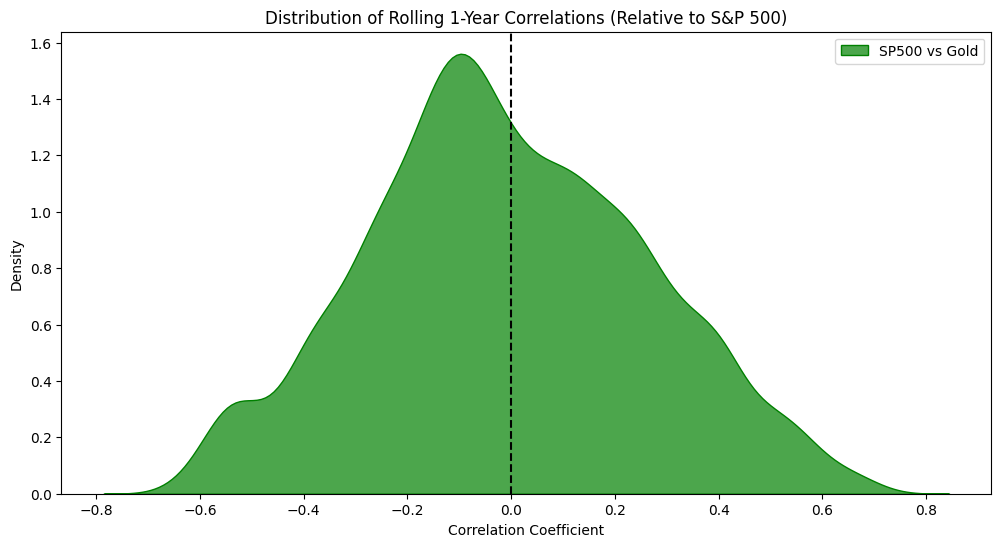

In [ ]:
# Calculating rolling 50 Correlations of Gold vs S&P 500
rolling_corr_gold = returns['SP500'].rolling(50).corr(returns['Gold'])

# Plotting the Distribution
plt.figure(figsize=(12, 6))
plt.title('Distribution of Rolling 1-Year Correlations (Relative to S&P 500)')
sns.kdeplot(rolling_corr_gold, label='SP500 vs Gold', color='green', fill=True, alpha=0.7)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Correlation Coefficient')
plt.legend()
plt.show()

In [ ]:
# There are 252 trading days in 1 year
rolling_correlation = returns['SP500'].rolling(window=50).corr(returns['Gold'])

# Plotting the dissection
fig = px.line(rolling_correlation,
              title='Dissecting 25 Years of Correlation: S&P 500 vs Gold (Rolling 1-Year Correlation)',
              labels={'value': 'Correlation Coefficient', 'index': 'Date'})

# Adding a zero-line for our reference
fig.add_hline(y=0, line_dash="dash", line_color="black")
fig.update_xaxes(rangeslider_visible=True)
fig.show()